# Frustrated Total Internal Reflection: Glass1 / Air / Glass2

Author: O. Castany, C. Molinaro, M. Müller

In [1]:
import elli
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import pi

## Structure definition

In [2]:
# Refractive indices
n_f = 1.5
n_s = 1.0
n_b = 1.7

# Materials:
glass1 = elli.IsotropicMaterial(elli.ConstantRefractiveIndex(n_f))
air = elli.IsotropicMaterial(elli.ConstantRefractiveIndex(n_s))
glass2 = elli.IsotropicMaterial(elli.ConstantRefractiveIndex(n_b))

# Layer:
layer = elli.Layer(air, 0)

# Structure:
s = elli.Structure(glass1, [layer], glass2)

# Wavelength and wavenumber:
lbda = 1000
k0 = 2 * pi / lbda

# Layer thickness
d = lbda * 0.347
layer.set_thickness(d)

# Variation of incidence angle
Phi_list = np.deg2rad(np.linspace(0, 89, 90))

Analytical calculation
Incidence angle

In [3]:
# Reduced wavenumber
Kx = n_f * np.sin(Phi_list)

Phi_s = np.arcsin((Kx / n_s).astype(complex))
Phi_b = np.arcsin((Kx / n_b).astype(complex))

# Wave vector:
kz_f = n_f * k0 * np.cos((Phi_list.astype(complex)))
kz_s = k0 * np.sqrt((-(Kx**2 - n_s**2)).astype(complex))
kz_b = n_b * k0 * np.cos(Phi_b)

# Amplitude coefficient for 's' polarisation:
r_sf_s = (kz_f - kz_s) / (kz_s + kz_f)
r_bs_s = (kz_s - kz_b) / (kz_s + kz_b)
t_sf_s = 1 + r_sf_s
t_bs_s = 1 + r_bs_s

# Amplitude coefficient for 'p' polarisation:
r_sf_p = (kz_f * n_s**2 - kz_s * n_f**2) / (kz_s * n_f**2 + kz_f * n_s**2)
r_bs_p = (kz_s * n_b**2 - kz_b * n_s**2) / (kz_s * n_b**2 + kz_b * n_s**2)
t_sf_p = np.cos((Phi_list.astype(complex))) * (1 - r_sf_p) / np.cos(Phi_s)
t_bs_p = np.cos(Phi_s) * (1 - r_bs_p) / np.cos(Phi_b)

# Power coefficients:
R_th_s = (
    np.abs(
        (r_sf_s + r_bs_s * np.exp(2j * kz_s * d))
        / (1 + r_bs_s * r_sf_s * np.exp(2j * kz_s * d))
    )
) ** 2

t2_th_s = (
    np.abs(
        (t_bs_s * t_sf_s * np.exp(1j * kz_s * d))
        / (1 + r_bs_s * r_sf_s * np.exp(2j * kz_s * d))
    )
) ** 2

R_th_p = (
    np.abs(
        (r_sf_p + r_bs_p * np.exp(2j * kz_s * d))
        / (1 + r_bs_p * r_sf_p * np.exp(2j * kz_s * d))
    )
) ** 2

t2_th_p = (
    np.abs(
        (t_bs_p * t_sf_p * np.exp(1j * kz_s * d))
        / (1 + r_bs_p * r_sf_p * np.exp(2j * kz_s * d))
    )
) ** 2

correction = np.real(n_b * np.cos(Phi_b) / (n_f * np.cos(Phi_list.astype(complex))))
# This is a correction term used in R +T*correction = 1

T_th_s = t2_th_s * correction
T_th_p = t2_th_p * correction

## Calculation with Berreman4x4

In [4]:
data = elli.ResultList([s.evaluate(lbda, np.rad2deg(Phi_i)) for Phi_i in Phi_list])

# Extraction of the transmission and reflexion coefficients
R_p = data.R_pp
R_s = data.R_ss
T_p = data.T_pp
T_s = data.T_ss
t2_p = np.abs(data.t_pp) ** 2  # Before power correction
t2_s = np.abs(data.t_ss) ** 2

## Plotting

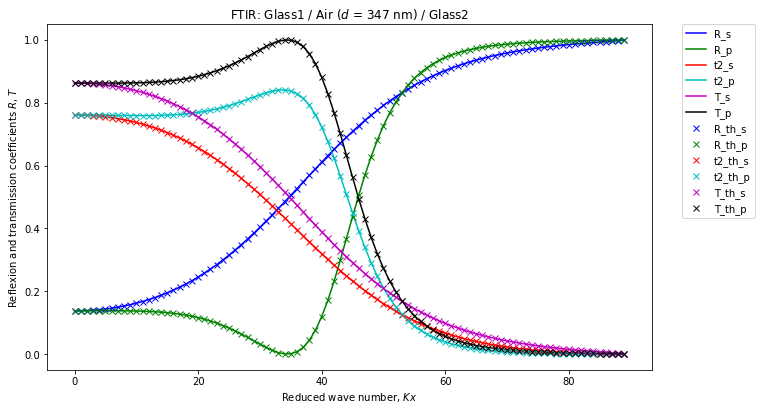

In [5]:
fig = plt.figure(figsize=(12.0, 6.0))
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", "bgrcmk")
ax = fig.add_axes([0.1, 0.1, 0.7, 0.8])

y = np.vstack((R_s, R_p, t2_s, t2_p, T_s, T_p)).T
legend1 = ("R_s", "R_p", "t2_s", "t2_p", "T_s", "T_p")
lines1 = ax.plot(np.rad2deg(Phi_list), y)

y_th = np.vstack((R_th_s, R_th_p, t2_th_s, t2_th_p, T_th_s, T_th_p)).T
legend2 = ("R_th_s", "R_th_p", "t2_th_s", "t2_th_p", "T_th_s", "T_th_p")
lines2 = ax.plot(np.rad2deg(Phi_list), y_th, "x")

ax.legend(
    lines1 + lines2,
    legend1 + legend2,
    loc="upper left",
    bbox_to_anchor=(1.05, 1),
    borderaxespad=0.0,
)

ax.set_title("FTIR: Glass1 / Air ($d$ = {:.3g} nm) / Glass2".format(d))
ax.set_xlabel(r"Reduced wave number, $Kx$")
ax.set_ylabel(r"Reflexion and transmission coefficients $R$, $T$")

plt.show()